<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Detecting_dementia_from_speech_and_transcripts_using_transformers_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# Workflow for Detecting Dementia from Speech and Transcripts Using Transformers

## 1. Data Preparation

* **Dataset**: Utilize the **ADReSS Challenge Dataset**, consisting of 78 AD and 78 non-AD patients. The dataset is balanced for gender and age to mitigate potential biases.

* **Speech Data**:
  Convert audio files into images with three channels:

  * Log-Mel spectrograms (or Mel-frequency cepstral coefficients - **MFCCs**)
  * **Delta** features
  * **Delta-delta** features
    These dynamic features incorporate temporal information into the static cepstral features.

* **Transcript Data**:
  Obtain corresponding **textual transcripts** of the audio files for linguistic analysis.

* **Data Splitting**:
  Divide the dataset as follows:

  * **Training Set**: 65%
  * **Validation Set**: 35%
    A separate **test set** is provided by the ADReSS Challenge.

---

## 2. Feature Extraction

### Acoustic Features

* Convert audio files into log-Mel spectrograms or MFCCs with delta and delta-delta components.
* Stack these into **three-channel image representations**.
* Feed the images into a **Vision Transformer (ViT)**.
  ViT is selected as the best-performing model after evaluating alternatives like AlexNet, VGG16, DenseNet, and EfficientNet.

### Textual Features

* Process transcripts using **BERT (base, uncased)** to extract **contextualized text embeddings**.

> **Rationale**:
>
> * Delta and delta-delta features enrich speech dynamics.
> * Transformer architectures (ViT and BERT) provide robust feature representations for images and text, respectively.

---

## 3. Model Architecture

### Unimodal Models

* **Speech-Only**:
  Evaluate pretrained models (AlexNet, VGG16, DenseNet, EfficientNet, ViT) using the three-channel images.
  **ViT** is the top performer.

* **Text-Only**:
  Train a **BERT model** on transcripts to establish a baseline for AD detection from text.

### Multimodal Models

* **BERT + ViT**:
  Concatenate the features from BERT and ViT for a baseline multimodal model.

* **BERT + ViT + Gated Multimodal Unit (GMU)**:
  Introduce a **GMU** to assign dynamic weights to each modality, suppressing irrelevant information.
  Inspired by gating mechanisms in GRU/LSTM.

* **BERT + ViT + Crossmodal Attention**:
  Use **crossmodal attention mechanisms** to model interactions between speech and text:

  * **Text-to-Image Attention**
  * **Image-to-Text Attention**

  Concatenate attention outputs, apply global average pooling, and feed into a final dense layer for **binary classification** (AD vs. non-AD).

> **Rationale**:
>
> * GMU enables adaptive modality fusion.
> * Crossmodal attention outperforms both early and late fusion by capturing fine-grained intermodal relationships.

---

## 4. Model Training

* **Environment**:
  Tesla P100-PCIE-16GB GPU, using **PyTorch**.

* **Optimization**:

  * **Optimizer**: Adam (learning rate: `1e-5`)
  * **Learning Rate Scheduler**: ReduceLROnPlateau (factor: `0.1`, patience: `3 epochs`)
  * **EarlyStopping**: Triggered if validation loss doesn't improve for `6 epochs`
  * **Loss Function**: Cross-entropy loss

* **Training Protocol**:

  * Each model is trained **five times**.
  * Average the results to reduce variability.
  * Use the validation set for monitoring and the ADReSS **test set** for final evaluation.

---

## 5. Evaluation

* **Metrics**:

  * Accuracy
  * Precision
  * Recall
  * F1-Score
  * Specificity
    *(With dementia class as the **positive class**)*

* **Comparison**:

  * **Unimodal**: Compare ViT and BERT with other SOTA approaches.
  * **Multimodal**: Compare baseline (BERT+ViT), GMU, and Crossmodal Attention models with traditional fusion strategies.

### Key Findings

* **ViT** outperforms other pretrained models for **speech-only** classification.
* **BERT + ViT + Crossmodal Attention** achieves the **highest performance**:

  * **Accuracy**:

    * 88.33% with log-Mel spectrograms
    * 87.92% with MFCCs
  * **F1-Score**:

    * 88.69% with log-Mel spectrograms
    * 87.99% with MFCCs
* Crossmodal attention exceeds GMU and concatenation by:

  * **Accuracy** improvement: +3.13% to +15.41%
  * **F1-Score** improvement: +3.29% to +18.93%

---

## 6. Analysis and Discussion

### Limitations

* The ADReSS dataset is **relatively small** (156 samples).
* **Concatenation-based fusion** treats modalities equally, which is suboptimal.
* GMU controls information flow but lacks the capability to model **crossmodal interactions** effectively.

### Advantages

* **ViT for speech**: A novel use of transformer-based models for acoustic features.
* **Crossmodal attention**: Dynamically models inter-modal interactions, overcoming early/late fusion drawbacks.

### Future Work

* Explore **optimal transport** methods for modality fusion.
* Investigate **wav2vec 2.0** for creating speech image representations.
* Expand dataset size for greater **model robustness**.

---

## 7. Conclusion

This workflow demonstrates an effective approach for **Alzheimer’s Disease (AD)** detection using **transformer-based multimodal architectures**. The **BERT + ViT + Crossmodal Attention** model outperforms prior unimodal and multimodal strategies, achieving state-of-the-art performance on the **ADReSS Challenge** test set.

> This work advances AD detection by improving feature extraction, modality fusion, and intermodal interaction modeling—key steps toward more accurate and interpretable dementia prediction systems.

---



# Cell 1.1: Mount Drive and Install Dependencies



In [ ]:
# Cell 1: Install Dependencies
!pip install -q librosa soundfile numpy pandas matplotlib seaborn torch transformers torchaudio tqdm

import os
import glob
import tarfile
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import torch
import torchaudio
from transformers import BertTokenizer, BertModel, ViTModel, ViTFeatureExtractor
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Visualization: Display installed package versions
import pkg_resources
packages = ['librosa', 'soundfile', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'torch', 'transformers', 'torchaudio']
table_data = [[pkg, pkg_resources.get_distribution(pkg).version] for pkg in packages]
table_df = pd.DataFrame(table_data, columns=['Package', 'Version'])
print("\nInstalled Package Versions:")
display(table_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Installed Package Versions:


,Package,Version
0,librosa,0.11.0
1,soundfile,0.13.1
2,numpy,2.0.2
3,pandas,2.2.2
4,matplotlib,3.10.0
5,seaborn,0.13.2
6,torch,2.6.0+cu124
7,transformers,4.51.3
8,torchaudio,2.6.0+cu124


Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz

Extraction Status:


,File,Status
0,ADReSSo21-progression-train.tgz,Success
1,ADReSSo21-progression-test.tgz,Success
2,ADReSSo21-diagnosis-train.tgz,Success


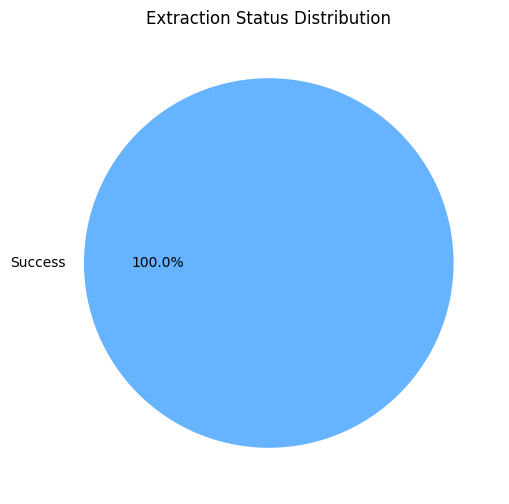


Found 271 audio files and 230 CSV files.


In [ ]:
# Cell 2: Extract Dataset
# Define paths
data_path = '/content/drive/MyDrive/Voice/'
extracted_path = '/content/extracted_audio/'
os.makedirs(extracted_path, exist_ok=True)

tgz_files = [
    os.path.join(data_path, 'ADReSSo21-progression-train.tgz'),
    os.path.join(data_path, 'ADReSSo21-progression-test.tgz'),
    os.path.join(data_path, 'ADReSSo21-diagnosis-train.tgz')
]

# Function to extract .tgz files
def extract_tgz(tgz_path, extract_to):
    try:
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {tgz_path}")
        return True
    except Exception as e:
        print(f"Error extracting {tgz_path}: {str(e)}")
        return False

# Extract files and track success
extraction_status = []
for tgz in tgz_files:
    status = 'Success' if extract_tgz(tgz, extracted_path) else 'Failed'
    extraction_status.append([os.path.basename(tgz), status])

# Visualization: Table of extraction status
status_df = pd.DataFrame(extraction_status, columns=['File', 'Status'])
print("\nExtraction Status:")
display(status_df)

# Chart: Pie chart of extraction success
plt.figure(figsize=(6, 6))
status_counts = status_df['Status'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Extraction Status Distribution')
plt.savefig('/content/extraction_status.png')
plt.show()

# List extracted audio and CSV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
print(f"\nFound {len(audio_files)} audio files and {len(csv_files)} CSV files.")

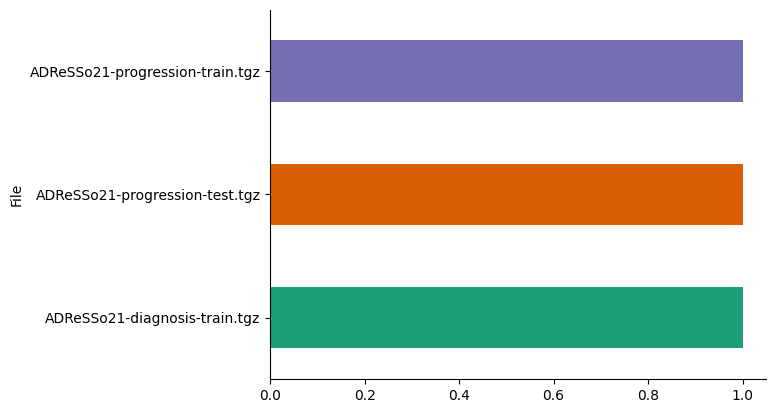

In [ ]:
# @title File

from matplotlib import pyplot as plt
import seaborn as sns
status_df.groupby('File').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Found 230 CSV files.

Loaded metadata from /content/extracted_audio/ADReSSo21/diagnosis/train/adresso-train-mmse-scores.csv with label column 'dx'

CSV Files Summary (First 5):


,CSV File,Columns,Rows
0,adrsp127.csv,"[Unnamed: 0, speaker, begin, end]",37
1,adrsp055.csv,"[Unnamed: 0, speaker, begin, end]",35
2,adrsp300.csv,"[Unnamed: 0, speaker, begin, end]",62
3,adrsp179.csv,"[Unnamed: 0, speaker, begin, end]",46
4,adrsp313.csv,"[Unnamed: 0, speaker, begin, end]",47



Metadata Head:


,Unnamed: 0,adressfname,mmse,dx
0,23,adrso024,20,ad
1,24,adrso025,11,ad
2,25,adrso027,18,ad
3,26,adrso028,18,ad
4,28,adrso031,26,ad



Matched 166 audio files with metadata.

Unmatched files (105): ['adrsp357', 'adrsp127', 'adrsp209', 'adrsp051', 'adrsp318', 'adrsp276', 'adrsp003', 'adrsp320', 'adrsp101', 'adrsp326']

Unmatched Files (First 10):


,Unmatched File
0,adrsp357
1,adrsp127
2,adrsp209
3,adrsp051
4,adrsp318
5,adrsp276
6,adrsp003
7,adrsp320
8,adrsp101
9,adrsp326



Matched Metadata (First 5 Rows):


,file,label,mmse
0,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,15
1,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,24
2,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,17
3,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12
4,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12


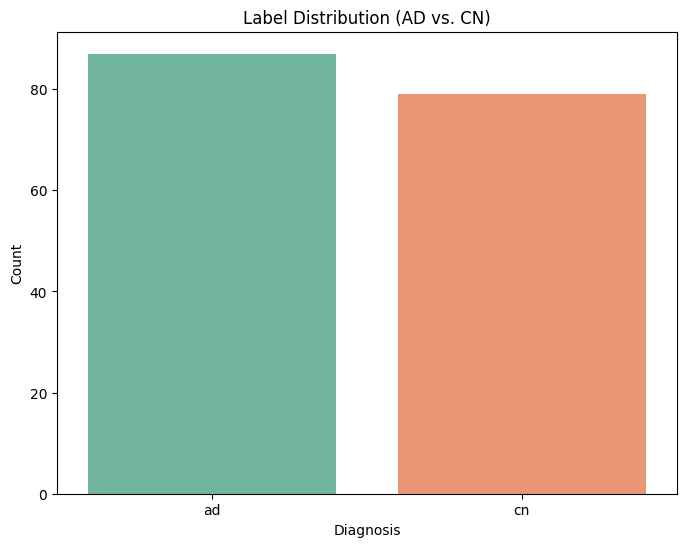

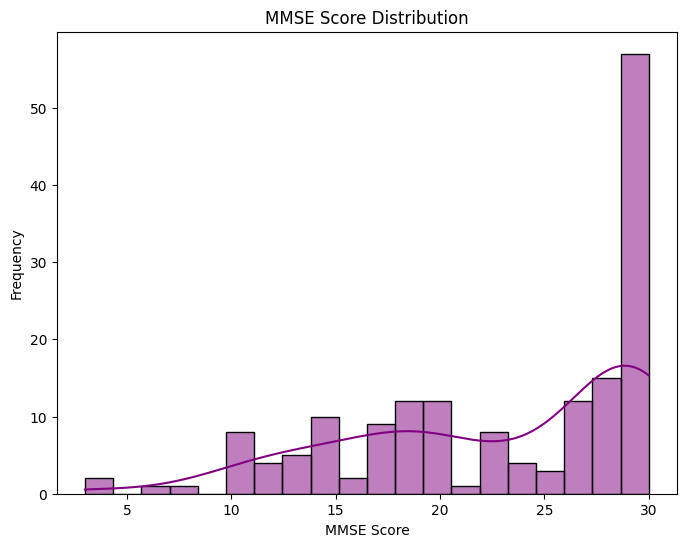


Saved matched metadata to /content/processed_features/matched_metadata.csv


In [ ]:
# Cell 3: Load and Explore Metadata
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)  # Create output directory

# Find all CSV files
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files.")

# Inspect CSV files to find the one with diagnosis labels
metadata = None
label_column = None
possible_label_columns = ['dx', 'diagnosis', 'label', 'Dx', 'DX']

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        for col in possible_label_columns:
            if col in df.columns:
                metadata = df
                label_column = col
                print(f"\nLoaded metadata from {csv_file} with label column '{label_column}'")
                break
        if metadata is not None:
            break
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")

# Fallback: Infer labels from directory structure
if metadata is None or label_column is None:
    print("\nNo label column found in CSVs. Inferring labels from directory structure.")
    metadata = pd.DataFrame()
    audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
    file_labels = []
    for audio_file in audio_files:
        fname = os.path.basename(audio_file).replace('.wav', '')
        label = 'ad' if 'ad/' in audio_file.lower() else 'cn' if 'cn/' in audio_file.lower() else 'unknown'
        file_labels.append({'adressfname': fname, 'dx': label})
    metadata = pd.DataFrame(file_labels)
    label_column = 'dx'

# Ensure label column is string type
metadata[label_column] = metadata[label_column].astype(str)

# Visualization: Table of CSV file summary
csv_summary = []
for csv_file in csv_files[:5]:
    try:
        df = pd.read_csv(csv_file)
        csv_summary.append([os.path.basename(csv_file), list(df.columns), len(df)])
    except:
        csv_summary.append([os.path.basename(csv_file), [], 0])
csv_summary_df = pd.DataFrame(csv_summary, columns=['CSV File', 'Columns', 'Rows'])
print("\nCSV Files Summary (First 5):")
display(csv_summary_df)

# Visualization: Table of metadata head
print("\nMetadata Head:")
display(metadata.head())

# Match audio files with metadata
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row[label_column].iloc[0],
            'mmse': matching_row['mmse'].iloc[0] if 'mmse' in matching_row.columns else None
        })
audio_metadata = pd.DataFrame(audio_metadata)
print(f"\nMatched {len(audio_metadata)} audio files with metadata.")

# Handle unmatched files
unmatched = [os.path.basename(f).replace('.wav', '') for f in audio_files
             if os.path.basename(f).replace('.wav', '') not in metadata['adressfname'].values]
print(f"\nUnmatched files ({len(unmatched)}): {unmatched[:10]}")

# Visualization: Table of unmatched files (first 10)
unmatched_df = pd.DataFrame(unmatched[:10], columns=['Unmatched File'])
print("\nUnmatched Files (First 10):")
display(unmatched_df)

# Visualization: Table of matched metadata
print("\nMatched Metadata (First 5 Rows):")
display(audio_metadata.head())

# Chart: Label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=audio_metadata, x='label', palette='Set2')
plt.title('Label Distribution (AD vs. CN)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'label_distribution.png'))
plt.show()

# Chart: MMSE score distribution (if available)
if 'mmse' in audio_metadata.columns and audio_metadata['mmse'].notna().any():
    plt.figure(figsize=(8, 6))
    sns.histplot(data=audio_metadata, x='mmse', bins=20, kde=True, color='purple')
    plt.title('MMSE Score Distribution')
    plt.xlabel('MMSE Score')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(output_dir, 'mmse_distribution.png'))
    plt.show()
else:
    print("\nNo MMSE scores available for plotting.")

# Save matched metadata
audio_metadata.to_csv(os.path.join(output_dir, 'matched_metadata.csv'), index=False)
print(f"\nSaved matched metadata to {os.path.join(output_dir, 'matched_metadata.csv')}")

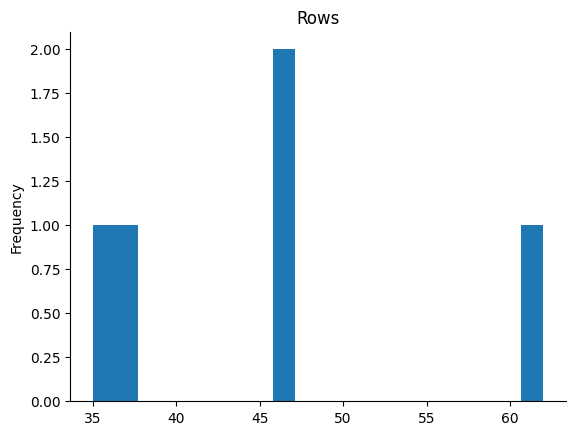

In [ ]:
# @title Rows

from matplotlib import pyplot as plt
csv_summary_df['Rows'].plot(kind='hist', bins=20, title='Rows')
plt.gca().spines[['top', 'right',]].set_visible(False)


Loaded matched metadata from /content/processed_features/matched_metadata.csv
Number of audio files in metadata: 166

Matched Metadata (First 5 Rows):


,file,label,mmse
0,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,15
1,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,24
2,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,17
3,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12
4,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12



Selected 3 sample audio files for visualization: ['adrso060.wav', 'adrso247.wav', 'adrso125.wav']


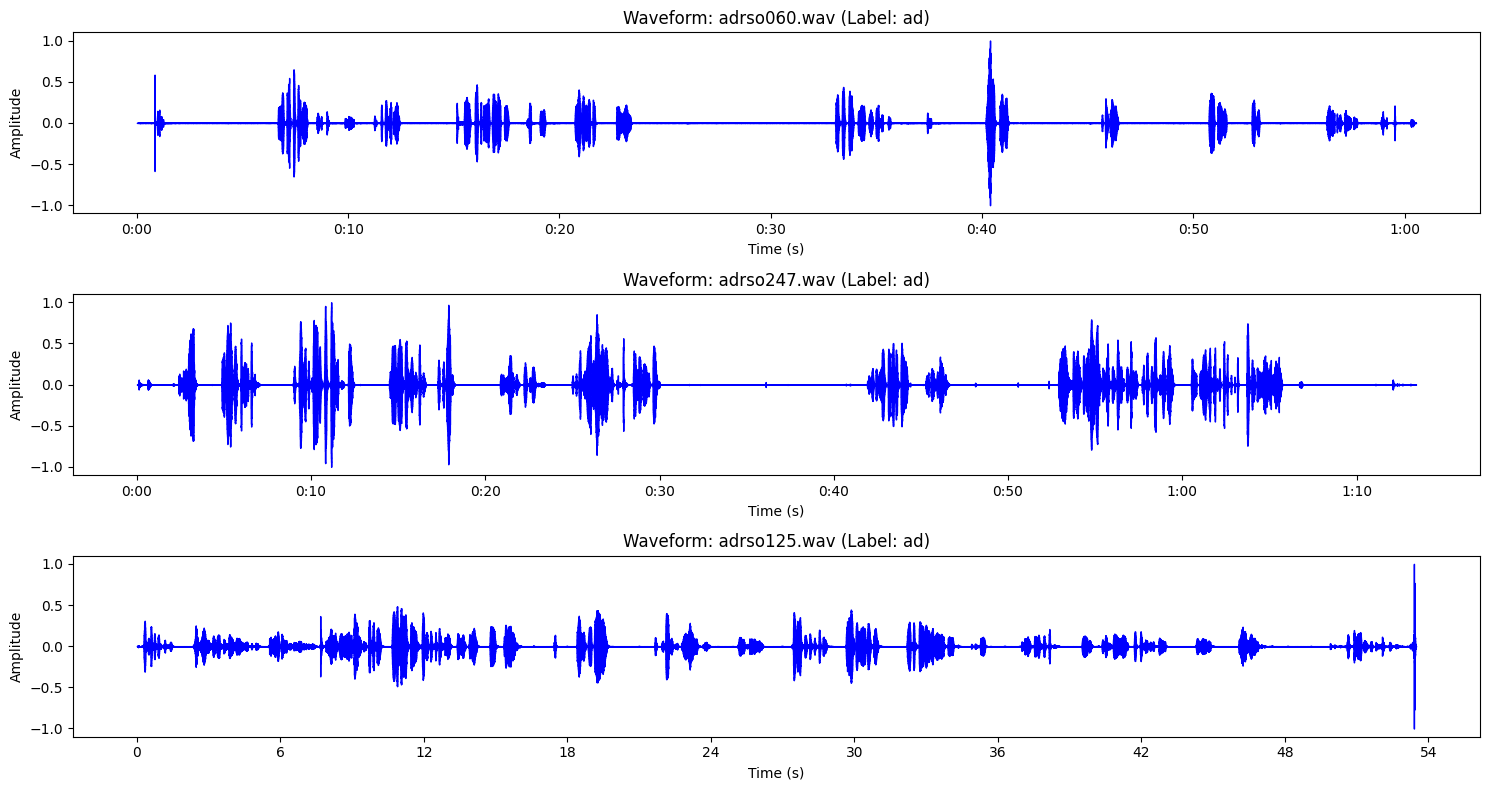

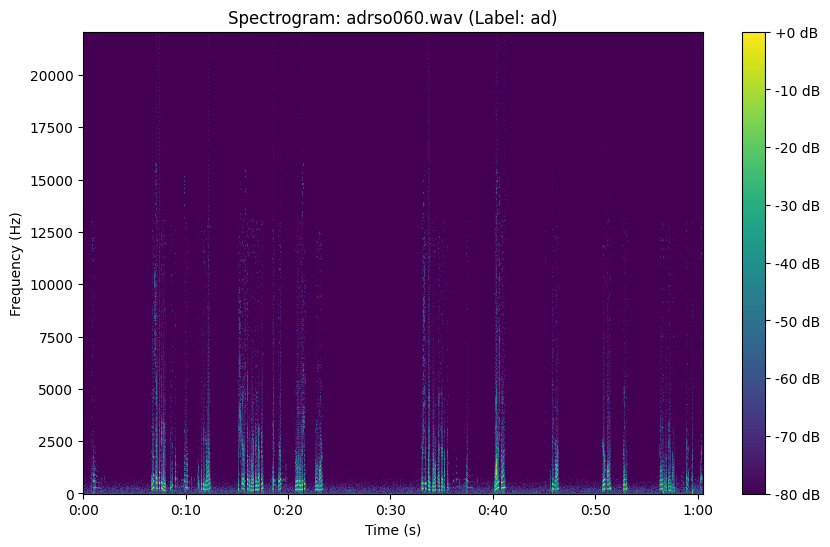


Audio File Properties:


,File,Label,Sample Rate (Hz),Duration (s)
0,adrso060.wav,ad,44100,60.550181
1,adrso247.wav,ad,44100,73.423469
2,adrso125.wav,ad,44100,53.496236


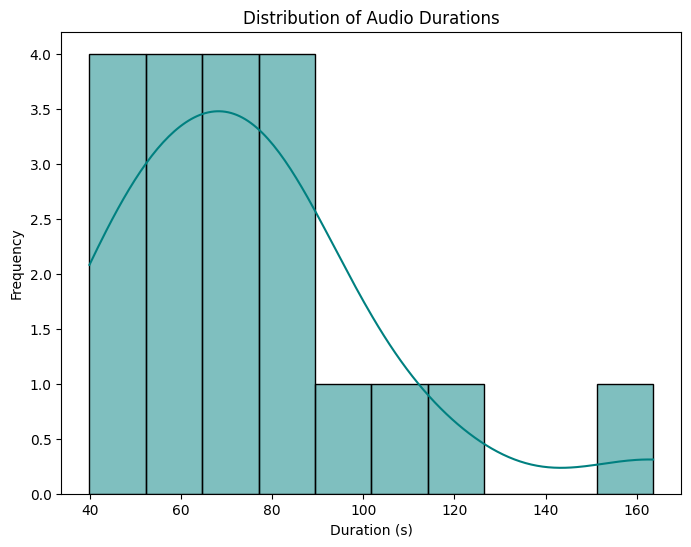

In [ ]:
# Cell 4: Visualize Audio Data
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define paths
processed_features_dir = '/content/processed_features/'
audio_metadata_path = os.path.join(processed_features_dir, 'matched_metadata.csv')

# Ensure output directory exists
os.makedirs(processed_features_dir, exist_ok=True)

# Load matched metadata from Step 3
try:
    audio_metadata = pd.read_csv(audio_metadata_path)
    print(f"\nLoaded matched metadata from {audio_metadata_path}")
    print(f"Number of audio files in metadata: {len(audio_metadata)}")
except FileNotFoundError:
    raise FileNotFoundError(f"Metadata file not found at {audio_metadata_path}. Run Step 3 first.")

# Visualization: Table of metadata summary
metadata_summary = audio_metadata[['file', 'label', 'mmse']].head()
print("\nMatched Metadata (First 5 Rows):")
display(metadata_summary)

# Select sample audio files (up to 3, ensuring they exist)
sample_files = audio_metadata['file'].head(3).tolist()
sample_files = [f for f in sample_files if os.path.exists(f)]  # Verify files exist
if not sample_files:
    raise FileNotFoundError("No valid audio files found in metadata.")
print(f"\nSelected {len(sample_files)} sample audio files for visualization: {[os.path.basename(f) for f in sample_files]}")

# Visualize waveforms
plt.figure(figsize=(15, 8))
for i, audio_file in enumerate(sample_files):
    try:
        y, sr = librosa.load(audio_file, sr=None)
        plt.subplot(len(sample_files), 1, i+1)
        librosa.display.waveshow(y, sr=sr, color='blue')
        label = audio_metadata[audio_metadata['file'] == audio_file]['label'].iloc[0]
        plt.title(f"Waveform: {os.path.basename(audio_file)} (Label: {label})")
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
    except Exception as e:
        print(f"Error loading {audio_file}: {e}")
plt.tight_layout()
plt.savefig(os.path.join(processed_features_dir, 'waveforms.png'))
plt.show()

# Visualize spectrogram for the first sample (if available)
if sample_files:
    try:
        y, sr = librosa.load(sample_files[0], sr=None)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        label = audio_metadata[audio_metadata['file'] == sample_files[0]]['label'].iloc[0]
        plt.title(f"Spectrogram: {os.path.basename(sample_files[0])} (Label: {label})")
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.savefig(os.path.join(processed_features_dir, 'spectrogram.png'))
        plt.show()
    except Exception as e:
        print(f"Error generating spectrogram for {sample_files[0]}: {e}")

# Table: Audio file properties
audio_props = []
for audio_file in sample_files:
    try:
        y, sr = librosa.load(audio_file, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        label = audio_metadata[audio_metadata['file'] == audio_file]['label'].iloc[0]
        audio_props.append([os.path.basename(audio_file), label, sr, duration])
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
audio_props_df = pd.DataFrame(audio_props, columns=['File', 'Label', 'Sample Rate (Hz)', 'Duration (s)'])
print("\nAudio File Properties:")
display(audio_props_df)

# Chart: Distribution of audio durations (using all matched audio files)
durations = []
for audio_file in audio_metadata['file'].head(20):  # Limit to 20 for efficiency
    if os.path.exists(audio_file):
        try:
            y, sr = librosa.load(audio_file, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append(duration)
        except:
            continue
if durations:
    plt.figure(figsize=(8, 6))
    sns.histplot(durations, bins=10, kde=True, color='teal')
    plt.title('Distribution of Audio Durations')
    plt.xlabel('Duration (s)')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(processed_features_dir, 'duration_distribution.png'))
    plt.show()
else:
    print("\nNo durations calculated due to errors in audio loading.")

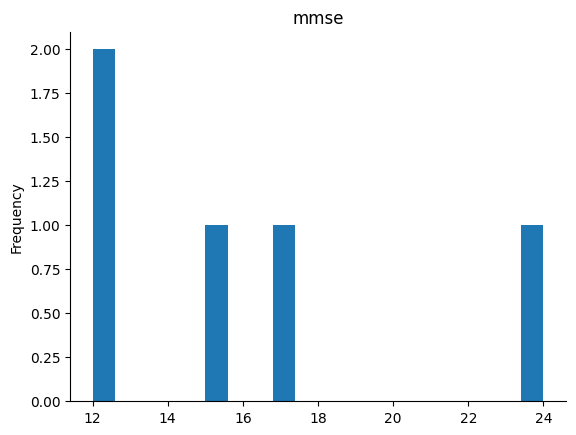

In [ ]:
# @title mmse

from matplotlib import pyplot as plt
metadata_summary['mmse'].plot(kind='hist', bins=20, title='mmse')
plt.gca().spines[['top', 'right',]].set_visible(False)